In [1]:
import docx
import os

import re
import pandas as pd
import numpy as np

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn')
# plt.style.use('grayscale')
%matplotlib inline

In [2]:
novel = []

for filename in os.listdir('text'):
    if filename == 'istanbul hatirasi ingilizce.docx':
        continue
    try:
        matches = re.search(r'([0-9]*)_([a-z]*)_', filename)
        position = int(matches[1])
        period = matches[2].replace('distant', 'Distant History')\
                           .replace('recent', 'Recent History')\
                           .replace('current', 'Current Day')\
                           .replace('detectivestory', 'Detective Story')
        doc = docx.Document('text/{}'.format(filename))
        text = '\n\n'.join(paragraph.text for paragraph in doc.paragraphs)
        novel.append([position, period, text])
    except TypeError:
        print(filename)

novel = sorted(novel, key=lambda x: x[0])

In [3]:
analyzer = SentimentIntensityAnalyzer()

In [4]:
for section in novel:
    sentences = tokenize.sent_tokenize(section[2])
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}

    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']

    sentiments['compound'] = sentiments['compound'] / len(sentences)
    sentiments['neg'] = sentiments['neg'] / len(sentences)
    sentiments['neu'] = sentiments['neu'] / len(sentences)
    sentiments['pos'] = sentiments['pos'] / len(sentences)
    section.append(len(sentences))
    section.append(sentiments)

In [5]:
df = pd.DataFrame({'section': [section[0] for section in novel],
                   'period': [section[1] for section in novel],
                   'text': [section[2] for section in novel],
                   'sentence_count': [section[3] for section in novel],
                   'compound': [section[4]['compound'] for section in novel],
                   'pos': [section[4]['pos'] for section in novel],
                   'neg': [section[4]['neg'] for section in novel],
                   'neu': [section[4]['neu'] for section in novel]})

In [6]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.069649,0.090073,0.061400,0.848527
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.121150,0.009125,0.061125,0.929750
2,3,Current Day,"Two battered old ferries, those long-suffering...",2,0.584200,0.140500,0.000000,0.859500
3,4,Recent History,"I was taken back to the old days, the good old...",1,0.685800,0.170000,0.058000,0.772000
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.068826,0.039953,0.075581,0.884465


In [7]:
df.describe()

,section,sentence_count,compound,pos,neg,neu
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,154.500000,36.863636,0.076693,0.075490,0.050623,0.873884
std,89.056162,88.643749,0.209823,0.050890,0.042271,0.063892
min,1.000000,1.000000,-0.648600,0.000000,0.000000,0.667000
25%,77.750000,3.000000,-0.040903,0.043923,0.016458,0.835789
50%,154.500000,7.500000,0.031555,0.068167,0.048696,0.870278
75%,231.250000,31.000000,0.169266,0.097921,0.077300,0.912536
max,308.000000,816.000000,0.877900,0.299667,0.292500,1.000000


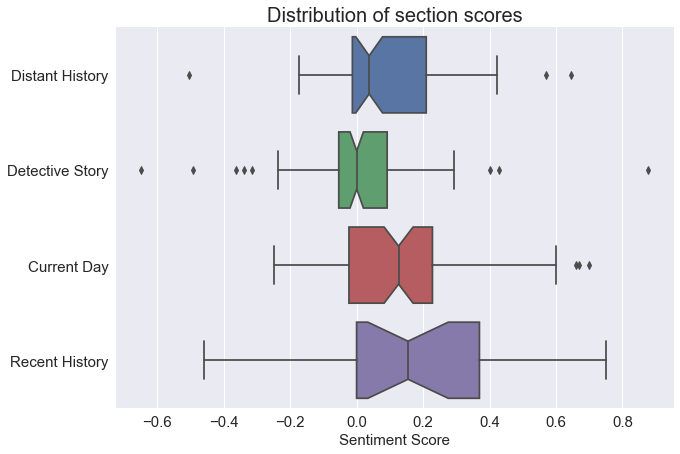

In [8]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df, notch=True)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

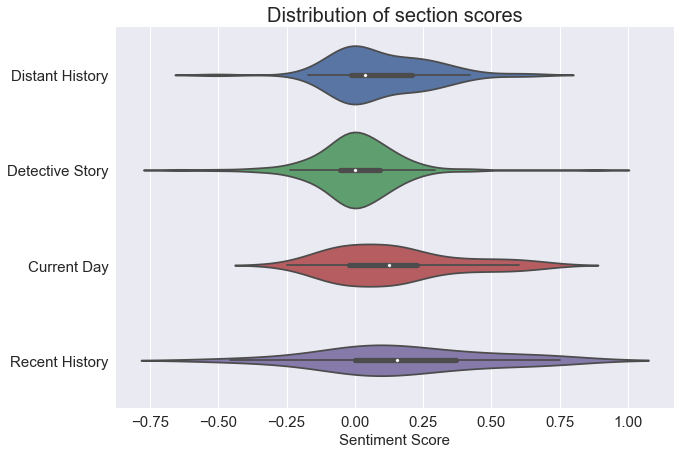

In [9]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='compound', y='period', data=df, notch=True)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [10]:
book_indices = {}
idx = 0
for section in novel:
    start = idx
    idx += section[3]
    book_indices[section[0]] = (start, idx, section[1])

In [11]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

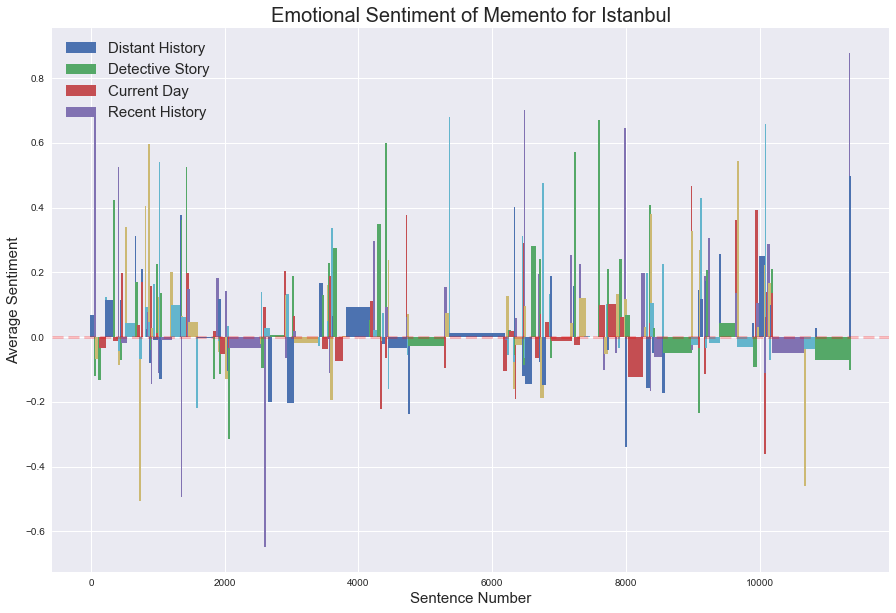

In [12]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

legend_items = {'Distant History': False, 'Detective Story': False, 'Current Day': False, 'Recent History': False}

plt.figure(figsize=(15, 10))
for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True
    plt.bar(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, width=25)
# plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of Memento for Istanbul', fontsize=20)
plt.xlabel('Sentence Number', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

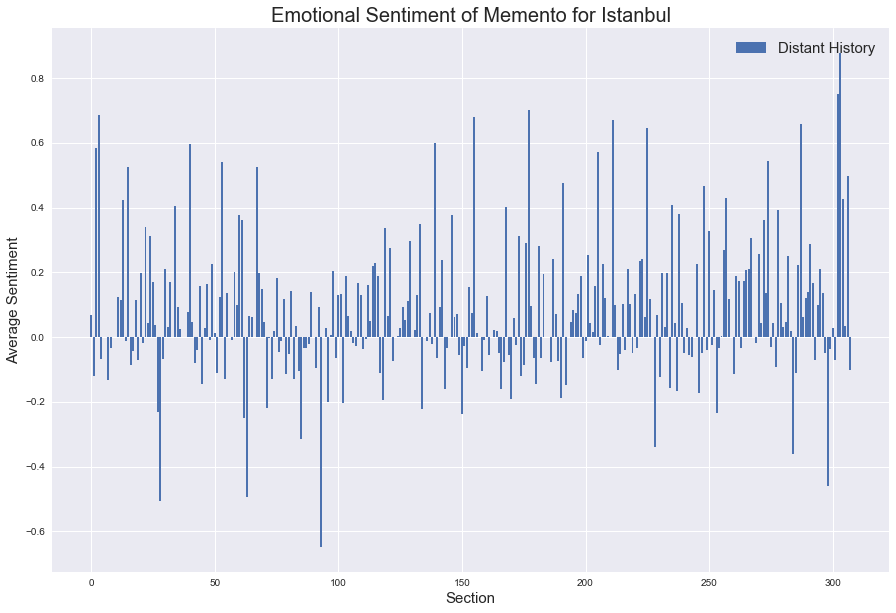

In [13]:
length = len(novel)
x = np.linspace(0, length - 1, num=length)
y = [section[4]['compound'] for section in novel]
label = [section[1] for section in novel]

plt.figure(figsize=(15, 10))
plt.bar(x, y, label=label)
# plt.plot(movingaverage(y, 25), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
# plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(['Distant History', 'Detective Story', 'Current Day', 'Recent History', 'Moving Average'], loc='upper right', fontsize=15)
plt.title('Emotional Sentiment of Memento for Istanbul', fontsize=20)
plt.xlabel('Section', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [14]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('NRC-Sentiment-Emotion-Lexicons/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    
    for i, row in new_df.iterrows():
        document = word_tokenize(new_df.loc[i][column])
        for word in document:
            word = stemmer.stem(word.lower())
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [15]:
df = text_emotion(df, 'text')
df['word_count'] = df['text'].apply(tokenize.word_tokenize).apply(len)
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    df[emotion] = df[emotion] / df['word_count']

In [16]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.069649,0.090073,0.061400,0.848527,0.017586,0.023981,0.007194,0.018385,0.015987,0.035971,0.068745,0.017586,0.007994,0.019984,1251
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.121150,0.009125,0.061125,0.929750,0.021164,0.026455,0.010582,0.021164,0.005291,0.026455,0.037037,0.015873,0.010582,0.021164,189
2,3,Current Day,"Two battered old ferries, those long-suffering...",2,0.584200,0.140500,0.000000,0.859500,0.030303,0.030303,0.015152,0.015152,0.030303,0.015152,0.075758,0.015152,0.030303,0.045455,66
3,4,Recent History,"I was taken back to the old days, the good old...",1,0.685800,0.170000,0.058000,0.772000,0.000000,0.019231,0.000000,0.000000,0.038462,0.019231,0.038462,0.019231,0.019231,0.019231,52
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.068826,0.039953,0.075581,0.884465,0.008761,0.012516,0.001252,0.015019,0.003755,0.030038,0.013767,0.013767,0.002503,0.008761,799


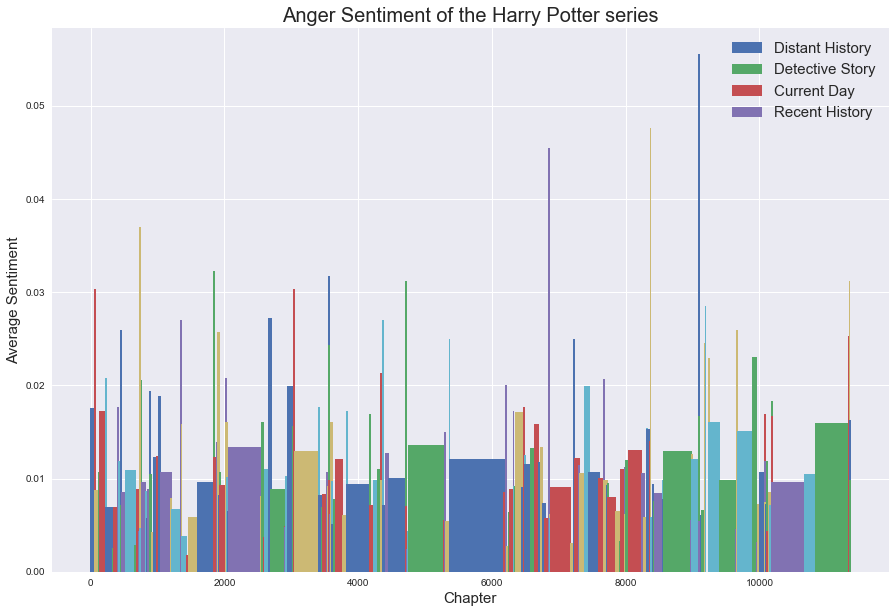

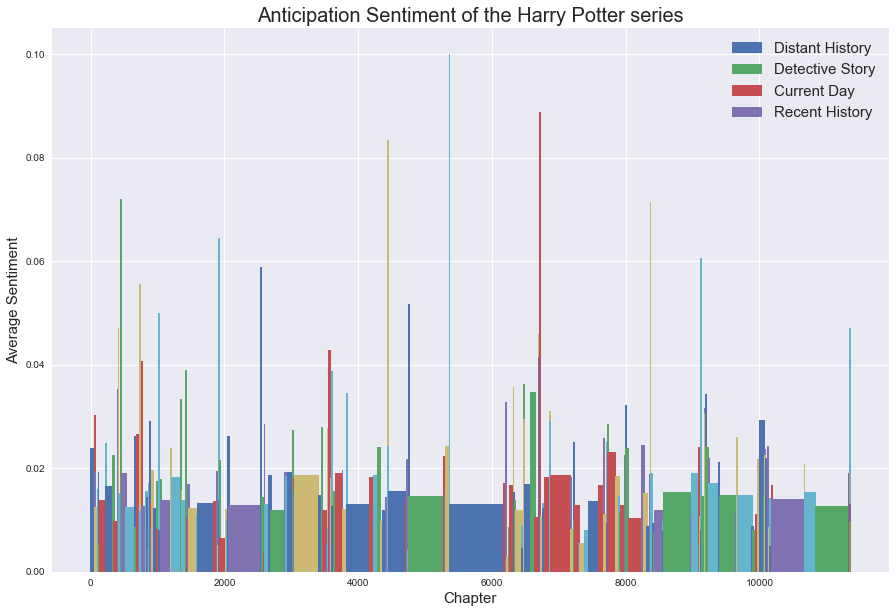

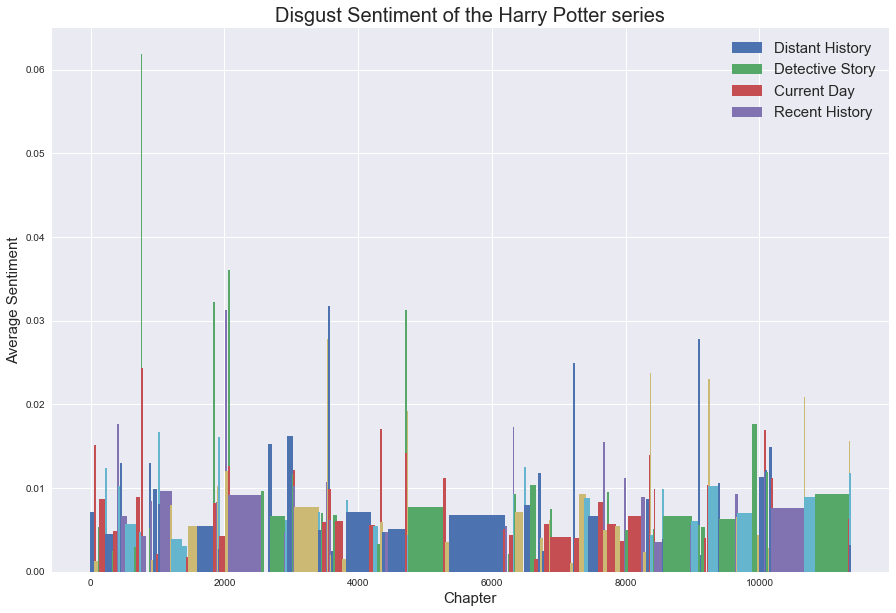

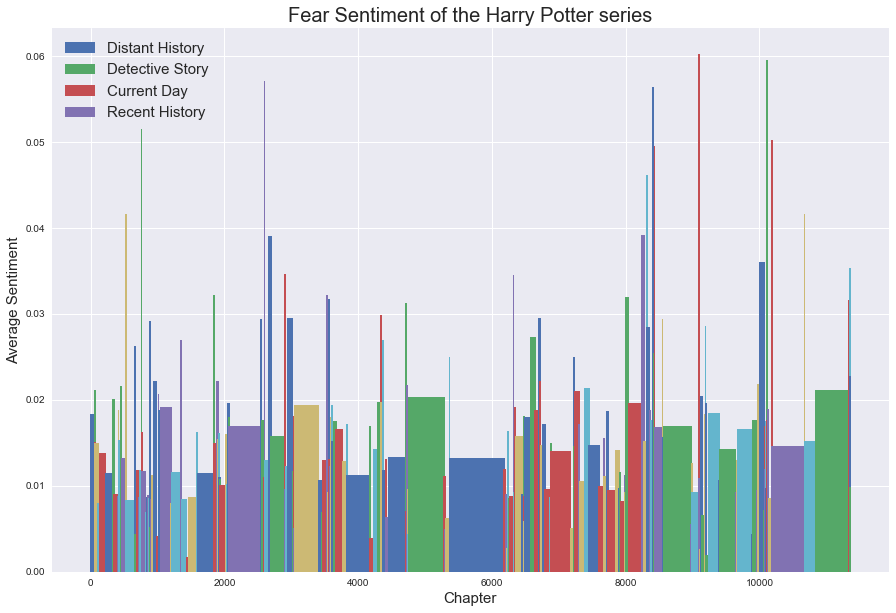

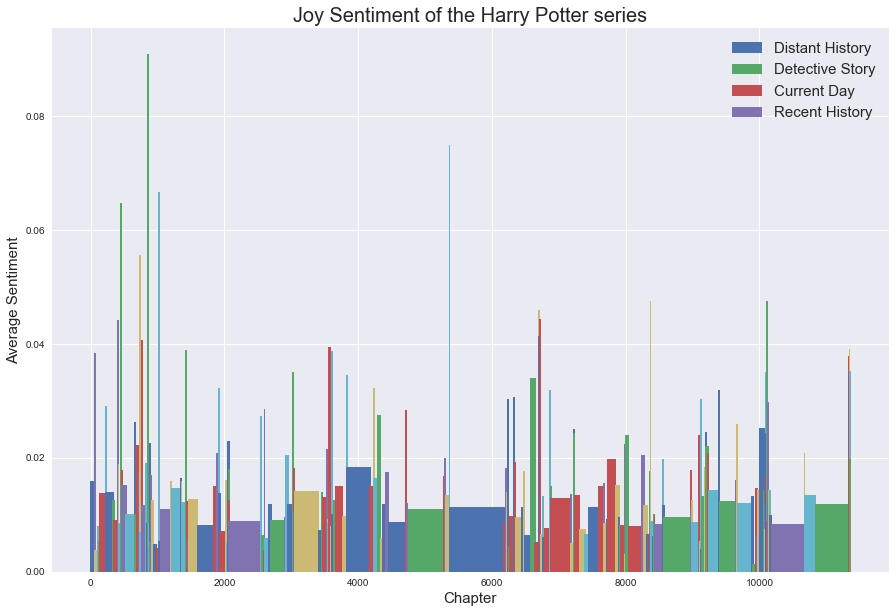

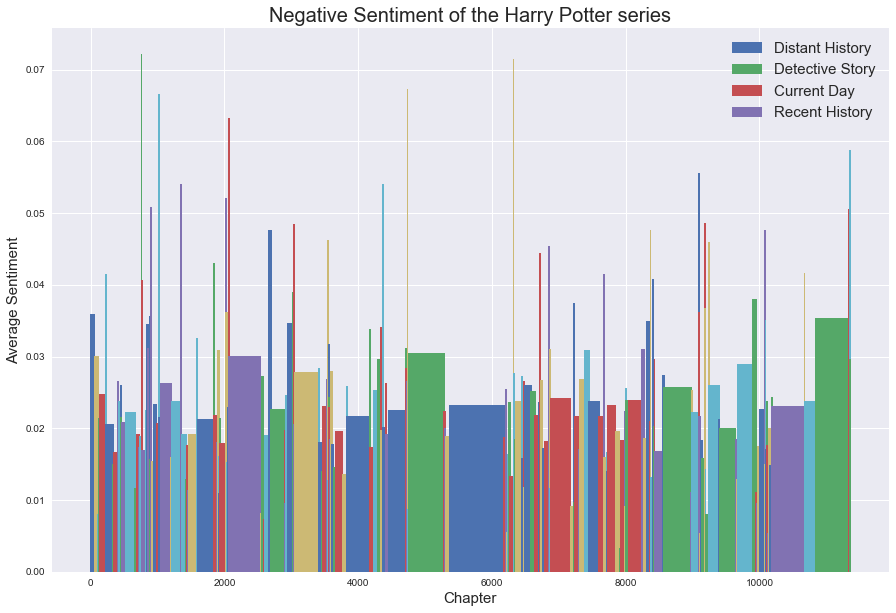

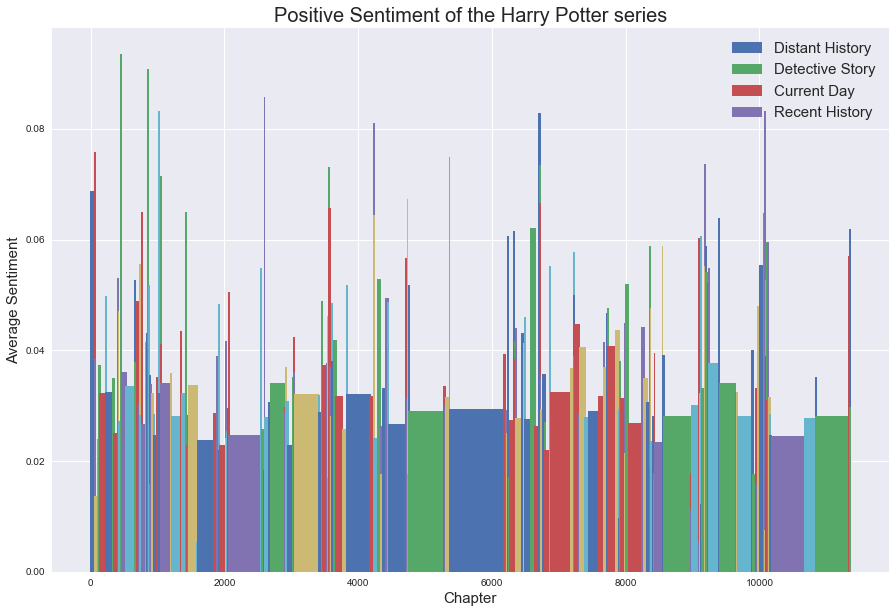

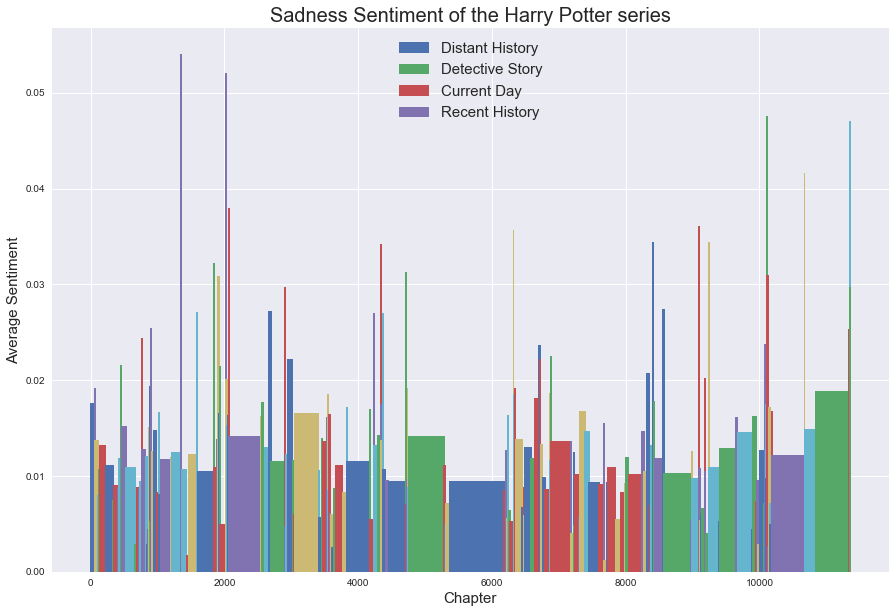

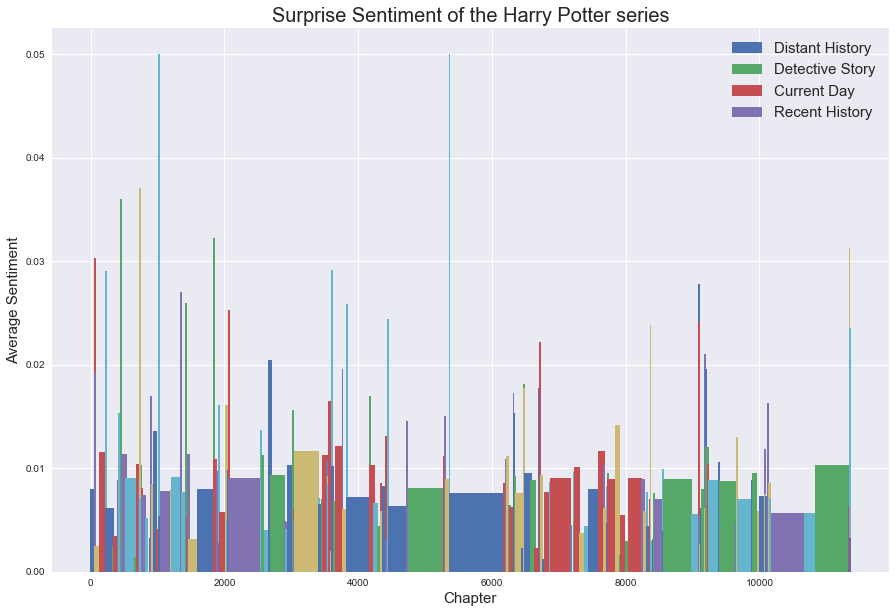

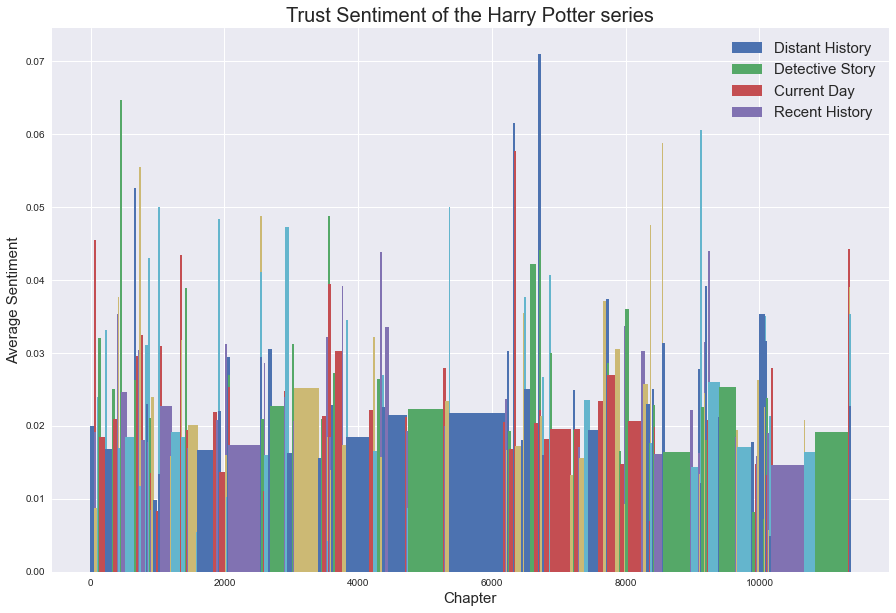

In [17]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [item for sublist in [[row[emotion]] * row['sentence_count'] for idx, row in df.iterrows()] for item in sublist]

    legend_items = {'Distant History': False, 'Detective Story': False, 'Current Day': False, 'Recent History': False}

    plt.figure(figsize=(15, 10))
    for section in book_indices:
        if legend_items[book_indices[section][2]]:
            label = ''
        else:
            label = book_indices[section][2]
            legend_items[book_indices[section][2]] = True
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=label, width=25)
#     plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label='Moving Average')
    plt.legend(loc='best', fontsize=15)
    plt.title('{} Sentiment of the Harry Potter series'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapter', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

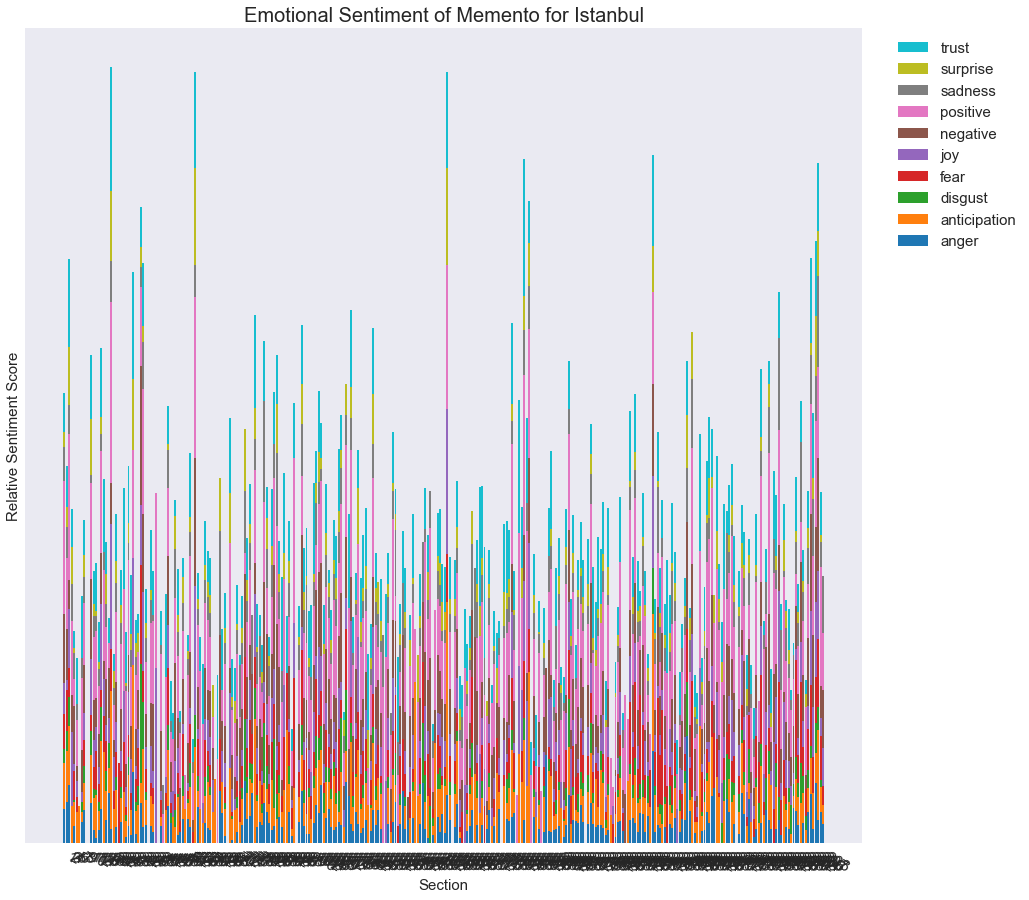

In [18]:
tab10 = matplotlib.cm.get_cmap('tab10')

sections = df['section'].tolist()
margin_bottom = np.zeros(len(sections))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = np.array(df[emotion])
    plt.bar(sections, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of Memento for Istanbul', fontsize=20)
plt.xticks(sections, sections, rotation=-30, ha='left', fontsize=15)
plt.xlabel('Section', fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
plt.yticks([])
ax.grid(False)
plt.show()

In [19]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.069649,0.090073,0.061400,0.848527,0.017586,0.023981,0.007194,0.018385,0.015987,0.035971,0.068745,0.017586,0.007994,0.019984,1251
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.121150,0.009125,0.061125,0.929750,0.021164,0.026455,0.010582,0.021164,0.005291,0.026455,0.037037,0.015873,0.010582,0.021164,189
2,3,Current Day,"Two battered old ferries, those long-suffering...",2,0.584200,0.140500,0.000000,0.859500,0.030303,0.030303,0.015152,0.015152,0.030303,0.015152,0.075758,0.015152,0.030303,0.045455,66
3,4,Recent History,"I was taken back to the old days, the good old...",1,0.685800,0.170000,0.058000,0.772000,0.000000,0.019231,0.000000,0.000000,0.038462,0.019231,0.038462,0.019231,0.019231,0.019231,52
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.068826,0.039953,0.075581,0.884465,0.008761,0.012516,0.001252,0.015019,0.003755,0.030038,0.013767,0.013767,0.002503,0.008761,799


In [20]:
df_ave = df.groupby('period')[['compound', 'pos', 'neg',
       'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust']].mean()

In [21]:
df_ave.head()

,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
period,,,,,,,,,,,,,,
Current Day,0.142744,0.082560,0.037913,0.879493,0.009290,0.016794,0.006720,0.009060,0.013212,0.020476,0.036389,0.010624,0.008323,0.020244
Detective Story,0.004815,0.072087,0.069192,0.858728,0.009551,0.014237,0.005533,0.013174,0.011686,0.021205,0.031238,0.011949,0.006969,0.019726
Distant History,0.094644,0.070968,0.038311,0.890732,0.007171,0.016683,0.004589,0.017897,0.012925,0.016626,0.036733,0.008468,0.006038,0.022131
Recent History,0.182693,0.083966,0.032749,0.883294,0.007282,0.022584,0.004475,0.011657,0.025590,0.020053,0.034961,0.011180,0.007860,0.021648


In [22]:
import operator
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# nltk for lemmatization
from nltk.stem import WordNetLemmatizer 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [23]:
data = [section[2].replace('\n', ' ') for section in novel]

In [24]:
text_df = df.groupby('period')['text'].apply(lambda x: ','.join(x)).reset_index()
data = text_df['text'].tolist()
text_df

,period,text
0,Current Day,"Two battered old ferries, those long-suffering..."
1,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...
2,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...
3,Recent History,"I was taken back to the old days, the good old..."


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [27]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(word) for word in sent])
    return texts_out

In [28]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

lemmatizer = WordNetLemmatizer() 

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"city" + 0.011*"emperor" + 0.009*"one" + 0.008*"would" + '
  '0.006*"sultan" + 0.006*"god" + 0.006*"built" + 0.006*"mosque" + '
  '0.005*"constantine" + 0.005*"said"'),
 (1,
  '0.001*"said" + 0.001*"one" + 0.000*"u" + 0.000*"city" + 0.000*"ali" + '
  '0.000*"would" + 0.000*"could" + 0.000*"two" + 0.000*"like" + '
  '0.000*"zeynep"'),
 (2,
  '0.002*"said" + 0.001*"one" + 0.001*"would" + 0.001*"u" + 0.001*"ali" + '
  '0.001*"like" + 0.001*"time" + 0.001*"know" + 0.000*"two" + 0.000*"say"'),
 (3,
  '0.001*"said" + 0.000*"would" + 0.000*"ali" + 0.000*"one" + 0.000*"city" + '
  '0.000*"like" + 0.000*"time" + 0.000*"u" + 0.000*"know" + 0.000*"two"'),
 (4,
  '0.001*"said" + 0.001*"one" + 0.001*"would" + 0.001*"ali" + 0.000*"u" + '
  '0.000*"city" + 0.000*"know" + 0.000*"could" + 0.000*"back" + 0.000*"like"'),
 (5,
  '0.001*"said" + 0.001*"one" + 0.000*"would" + 0.000*"ali" + 0.000*"u" + '
  '0.000*"like" + 0.000*"even" + 0.000*"could" + 0.000*"know" + 0.000*"time"'),
 (6,
  '0.0

In [32]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -8.109047141380252
Coherence Score:  0.26350146353366183


In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [34]:
mallet_path = r'C:\\mallet\\bin\\mallet.bat'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [35]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('told', 0.05963488843813387),
   ('read', 0.021095334685598377),
   ('fine', 0.019066937119675456),
   ('pointing', 0.017038539553752535),
   ('paused', 0.015010141987829614),
   ('dersaadet', 0.015010141987829614),
   ('whispered', 0.01460446247464503),
   ('answered', 0.013793103448275862),
   ('sarayburnu', 0.01257606490872211),
   ('half', 0.010953346855983773)]),
 (1,
  [('found', 0.05385520894643908),
   ('leyla_barkın', 0.036197763390229544),
   ('bos', 0.031194820482636845),
   ('office', 0.02207180694526192),
   ('leave', 0.02207180694526192),
   ('walked', 0.02118893466745144),
   ('hour', 0.01912889935256033),
   ('museum', 0.016774573278399058),
   ('coming', 0.016185991759858742),
   ('part', 0.015008828722778105)]),
 (2,
  [('good', 0.04906832298136646),
   ('day', 0.044099378881987575),
   ('place', 0.03633540372670808),
   ('home', 0.02701863354037267),
   ('started', 0.02422360248447205),
   ('inside', 0.02236024844720497),
   ('poor', 0.01956521739130435),
  

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


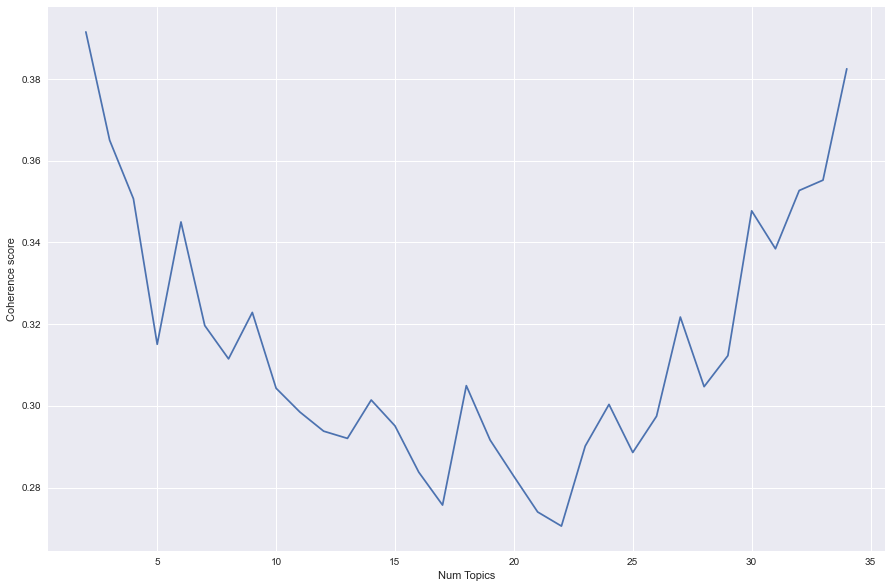

In [38]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

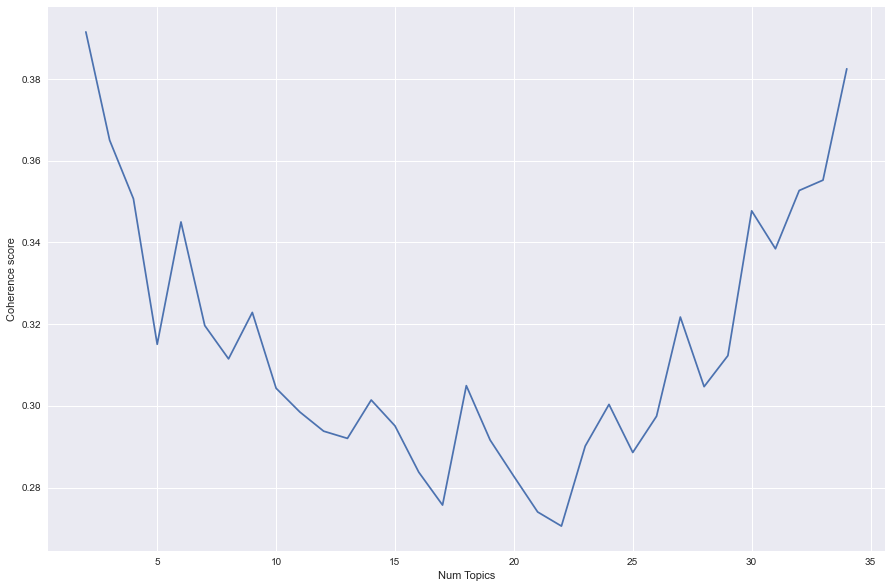

In [39]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.391535
Num Topics = 3  has Coherence Value of 0.365022
Num Topics = 4  has Coherence Value of 0.350701
Num Topics = 5  has Coherence Value of 0.315074
Num Topics = 6  has Coherence Value of 0.34502
Num Topics = 7  has Coherence Value of 0.319664
Num Topics = 8  has Coherence Value of 0.311512
Num Topics = 9  has Coherence Value of 0.322874
Num Topics = 10  has Coherence Value of 0.304321
Num Topics = 11  has Coherence Value of 0.298498
Num Topics = 12  has Coherence Value of 0.293812
Num Topics = 13  has Coherence Value of 0.292046
Num Topics = 14  has Coherence Value of 0.301439
Num Topics = 15  has Coherence Value of 0.295105
Num Topics = 16  has Coherence Value of 0.283775
Num Topics = 17  has Coherence Value of 0.275724
Num Topics = 18  has Coherence Value of 0.304949
Num Topics = 19  has Coherence Value of 0.291653
Num Topics = 20  has Coherence Value of 0.28275
Num Topics = 21  has Coherence Value of 0.274033
Num Topics = 22  has Coherence

In [55]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 4
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.022*"time" + 0.021*"yekta" + 0.016*"head" + 0.016*"found" + '
  '0.012*"leyla_barkın" + 0.012*"bos" + 0.011*"moment" + 0.011*"word" + '
  '0.010*"necdet" + 0.009*"mind"'),
 (1,
  '0.015*"city" + 0.014*"mosque" + 0.013*"palace" + 0.013*"istanbul" + '
  '0.012*"wall" + 0.012*"time" + 0.012*"world" + 0.011*"man" + 0.011*"day" + '
  '0.011*"year"'),
 (2,
  '0.029*"back" + 0.027*"eye" + 0.018*"face" + 0.017*"body" + 0.016*"work" + '
  '0.014*"thing" + 0.014*"good" + 0.012*"guy" + 0.011*"people" + '
  '0.010*"question"'),
 (3,
  '0.015*"looked" + 0.013*"life" + 0.013*"turned" + 0.010*"front" + '
  '0.010*"door" + 0.010*"made" + 0.010*"thought" + 0.009*"felt" + '
  '0.009*"woman" + 0.008*"end"'),
 (4,
  '0.044*"ali" + 0.020*"zeynep" + 0.019*"demir" + 0.016*"hand" + 0.016*"coin" '
  '+ 0.016*"asked" + 0.014*"killer" + 0.013*"man" + 0.012*"evgenia" + '
  '0.012*"victim"'),
 (5,
  '0.027*"city" + 0.022*"emperor" + 0.018*"built" + 0.015*"god" + '
  '0.015*"sultan" + 0.014*"constantine" 

In [56]:
optimal_model.show_topic(0,10)

[('time', 0.021673577082548058),
 ('yekta', 0.020919713531850737),
 ('head', 0.0158311345646438),
 ('found', 0.015736901620806633),
 ('leyla_barkın', 0.011590652091971354),
 ('bos', 0.011590652091971354),
 ('moment', 0.010836788541274029),
 ('word', 0.010836788541274029),
 ('necdet', 0.010082924990576706),
 ('mind', 0.00895212966453072)]

In [57]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['time', 'yekta', 'head', 'found', 'leyla_barkın', 'bos', 'moment', 'word', 'necdet', 'mind']
Topic 1: ['city', 'mosque', 'palace', 'istanbul', 'wall', 'time', 'world', 'man', 'day', 'year']
Topic 2: ['back', 'eye', 'face', 'body', 'work', 'thing', 'good', 'guy', 'people', 'question']
Topic 3: ['looked', 'life', 'turned', 'front', 'door', 'made', 'thought', 'felt', 'woman', 'end']
Topic 4: ['ali', 'zeynep', 'demir', 'hand', 'coin', 'asked', 'killer', 'man', 'evgenia', 'victim']
Topic 5: ['city', 'emperor', 'built', 'god', 'sultan', 'constantine', 'ottoman', 'justinian', 'deity', 'mosque']


In [72]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1.0,0.4770,"city, mosque, palace, istanbul, wall, time, world, man, day, year"
1,1,4.0,0.2589,"ali, zeynep, demir, hand, coin, asked, killer, man, evgenia, victim"
2,2,5.0,0.5135,"city, emperor, built, god, sultan, constantine, ottoman, justinian, deity, mosque"
3,3,1.0,0.3930,"city, mosque, palace, istanbul, wall, time, world, man, day, year"


In [63]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])][['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1.0,0.477,"city, mosque, palace, istanbul, wall, time, world, man, day, year"
3,3,1.0,0.393,"city, mosque, palace, istanbul, wall, time, world, man, day, year"


In [64]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['city', 'mosque', 'palace', 'istanbul', 'wall']
1. Dominant keywords: ['ali', 'zeynep', 'demir', 'hand', 'coin']
2. Dominant keywords: ['city', 'emperor', 'built', 'god', 'sultan']
3. Dominant keywords: ['city', 'mosque', 'palace', 'istanbul', 'wall']


In [67]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet[['Topic_Num', "Topic_Perc_Contrib", "Keywords"]]

,Topic_Num,Topic_Perc_Contrib,Keywords
0,1.0,0.4770,"city, mosque, palace, istanbul, wall, time, world, man, day, year"
1,4.0,0.2589,"ali, zeynep, demir, hand, coin, asked, killer, man, evgenia, victim"
2,5.0,0.5135,"city, emperor, built, god, sultan, constantine, ottoman, justinian, deity, mosque"


In [69]:
# for idx, row in sent_topics_sorteddf_mallet.iterrows():
#     print('Topic number {}'.format(int(row['Topic_Num'])))
#     print('Keywords: {}'.format(row['Keywords']))
#     print()
#     print(row['Text'])
#     print()

In [70]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,1.0,"city, mosque, palace, istanbul, wall, time, world, man, day, year",NaN,NaN
1.0,4.0,"ali, zeynep, demir, hand, coin, asked, killer, man, evgenia, victim",2.0,0.50
2.0,5.0,"city, emperor, built, god, sultan, constantine, ottoman, justinian, deity, mosque",NaN,NaN
4.0,NaN,NaN,1.0,0.25
5.0,NaN,NaN,1.0,0.25


In [71]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

<ipython-input-71-ac90e0fd5d9d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,1.0,"city, mosque, palace, istanbul, wall, time, world, man, day, year",NaN,NaN
1.0,4.0,"ali, zeynep, demir, hand, coin, asked, killer, man, evgenia, victim",2.0,0.50
2.0,5.0,"city, emperor, built, god, sultan, constantine, ottoman, justinian, deity, mosque",NaN,NaN
4.0,NaN,NaN,1.0,0.25
5.0,NaN,NaN,1.0,0.25
